## Table of Contents
[1. Data Load and Preview](#1)<br/>
    [1.1 Data Load<br/>](#2)
    [1.2 Data Checks<br/>](#3)
        [1.2.1 Type check and change](#4)<br/>
        [1.2.2 Null and Duplicates Detection](#5)<br/>
        [1.2.3 Clean and Refine](#6)<br/>
    1.3 Categorical Feature Analysis <br/>
    1.4 Numerical Feature Analysis<br/>
    1.5 Time Series Analysis<br/>
2. Model Selection & Metrics Check<br/>
    2.1 SARIMA<br/>
    2.2 LSTM <br/>
    2.3 VAR (optional)
   

#### Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno 

## 1. Data Load and Preview

### 1.1 Data Load

In [2]:
sp = pd.read_csv('Sales  Product Price by Store.csv', index_col=False)
ap = pd.read_csv('Actual Prices.csv', index_col=False, header=1)
display(ap.head())
sp.head()

,Week,1,2,3
0,11/2/12,10.99,6.99,21.99
1,11/9/12,10.99,6.99,21.99
2,11/16/12,10.99,6.99,21.99
3,11/23/12,7.99,6.99,21.99
4,11/30/12,7.99,6.99,21.99


,Store,Product,Date,Is_Holiday,Base Price,Price,Weekly_Units_Sold
0,1,1,2/5/2010,False,9.99,7.99,245
1,1,1,2/12/2010,True,9.99,7.99,453
2,1,1,2/19/2010,False,9.99,7.99,409
3,1,1,2/26/2010,False,9.99,7.99,191
4,1,1,3/5/2010,False,9.99,9.99,145


### 1.2 Data Checks

#### 1.2.1 Type check and convert

In [3]:
print(sp.info())
print('\n')
print(ap.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3861 entries, 0 to 3860
Data columns (total 7 columns):
Store                3861 non-null int64
Product              3861 non-null int64
Date                 3861 non-null object
Is_Holiday           3861 non-null bool
Base Price           3861 non-null float64
Price                3861 non-null float64
Weekly_Units_Sold    3861 non-null int64
dtypes: bool(1), float64(2), int64(3), object(1)
memory usage: 184.9+ KB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 4 columns):
Week    12 non-null object
1       12 non-null float64
2       12 non-null float64
3       12 non-null float64
dtypes: float64(3), object(1)
memory usage: 512.0+ bytes
None


In [4]:
#Covert datetime to datetime type
sp['Date'] = pd.to_datetime(sp.Date)
ap['Week'] = pd.to_datetime(ap.Week)
# sp.info(), ap.info()

In [5]:
#Covert Is_Holiday variable from bool to numeric with 0 as False and 1 as True
H = {}
for i in range(len(sp.Is_Holiday)):
    if sp.Is_Holiday[i]:
        H[i] = 1
    else:
        H[i] = 0

sp['Is_Holiday'] = sp.index.map(H)

In [6]:
'''
set categorical data
'''
# sp['Store'] = sp['Store'].astype('category')
# sp['Product'] = sp['Product'].astype('category')
# sp['Is_Holiday'] = sp['Is_Holiday'].astype('category')

'\nset categorical data\n'

In [7]:
ap.index = ap.Week
ap.drop(columns=['Week'], inplace=True)

#### 1.2.2 Nulls and Duplicates Detection

In [8]:
class NullDuplicatesDetect(object):
    
    def null_detect(self, df):
        if len(df[df.isnull().any(axis=1)] != 0):
            print("\nPreview of data with null values:\nxxxxxxxxxxxxx")
            print("\n", df.isnull().sum(axis=0))
            print(df[df.isnull().any(axis=1)].head(3))
            missingno.matrix(df)
            plt.show()
        else:
            print('No Nulls')
        
        
    def dupli_detect(self, df):
        if len(df[df.duplicated()]) > 0:
            print("No. of duplicated entries: ", len(df[df.duplicated()]))
            print(df[df.duplicated(keep=False)].sort_values(by=list(df.columns)).head())
        else:
            print("No duplicated entries found")

In [9]:
detect = NullDuplicatesDetect()

In [10]:
detect.null_detect(sp)
detect.dupli_detect(sp)

No Nulls
No duplicated entries found


## Class for Categorical and Numeric features analysis

In [29]:
class CateNum(object):
    
    def cate_analy(self, df):
        """Given dataframe, generate analysis of categorical data"""
        print("To check: Unique count of non-numeric data")
        print(df.select_dtypes(include=['category']).nunique())
        self.top5(df)
        # Plot count distribution of categorical data
        for col in df.select_dtypes(include='category').columns:
            fig = sns.catplot(x=col, kind="count", data=df)
            fig.set_xticklabels(rotation=90)
            plt.show()
            
    def numeric_eda(self, df, hue=False):
        """Given dataframe, generate analysis of numeric data"""
        print("\nTo check: \nDistribution of numeric data")
        display(df.describe())
        columns = df.select_dtypes(include=np.number).columns
        figure = plt.figure(figsize=(20, 10))
        figure.add_subplot(1, len(columns), 1)
        for index, col in enumerate(columns):
            if index > 0:
                figure.add_subplot(1, len(columns), index + 1)
            sns.boxplot(y=col, data=df, boxprops={'facecolor': 'None'})
        figure.tight_layout()
        plt.show()

        if len(df.select_dtypes(include='category').columns) > 0:
            for col_num in df.select_dtypes(include=np.number).columns:
                for col in df.select_dtypes(include='category').columns:
                    fig = sns.catplot(x=col, y=col_num, kind='violin', data=df, height=5, aspect=2)
                    fig.set_xticklabels(rotation=90)
                    plt.show()

        # Plot the pairwise joint distributions
        print("\nTo check pairwise joint distribution of numeric data")
        if hue:
            sns.pairplot(df.select_dtypes(include=np.number), hue=hue)
        else:
            sns.pairplot(df.select_dtypes(include=np.number))
        plt.show() 
        
    def top5(self, df):
        """Given dataframe, generate top 5 unique values for non-numeric data"""
        columns = df.select_dtypes(include=['object', 'category']).columns
        for col in columns:
            print("Top 5 unique values of " + col)
            print(df[col].value_counts().reset_index().rename(columns={"index": col, col: "Count"})[
                  :min(5, len(df[col].value_counts()))])
            print(" ")

In [30]:
ana = CateNum()

### 1.3 Categorical Analysis

In [17]:
ana.cate_analy(sp)

To check: Unique count of non-numeric data
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[3861 rows x 0 columns]


In [23]:
sp.select_dtypes(include=np.number).join(sp[['Is_Holiday']])

ValueError: columns overlap but no suffix specified: Index(['Is_Holiday'], dtype='object')


To check: 
Distribution of numeric data


,Store,Product,Is_Holiday,Base Price,Price,Weekly_Units_Sold
count,3861.000000,3861.000000,3861.000000,3861.000000,3861.000000,3861.000000
mean,5.111111,2.000000,0.069930,12.554103,11.766084,215.952603
std,2.767003,0.816602,0.255062,6.079043,5.976196,236.273397
min,1.000000,1.000000,0.000000,5.990000,4.010000,13.000000
25%,3.000000,1.000000,0.000000,6.990000,5.990000,69.000000
50%,5.000000,2.000000,0.000000,10.990000,10.000000,130.000000
75%,7.000000,3.000000,0.000000,19.990000,19.990000,278.000000
max,10.000000,3.000000,1.000000,21.990000,21.990000,2557.000000


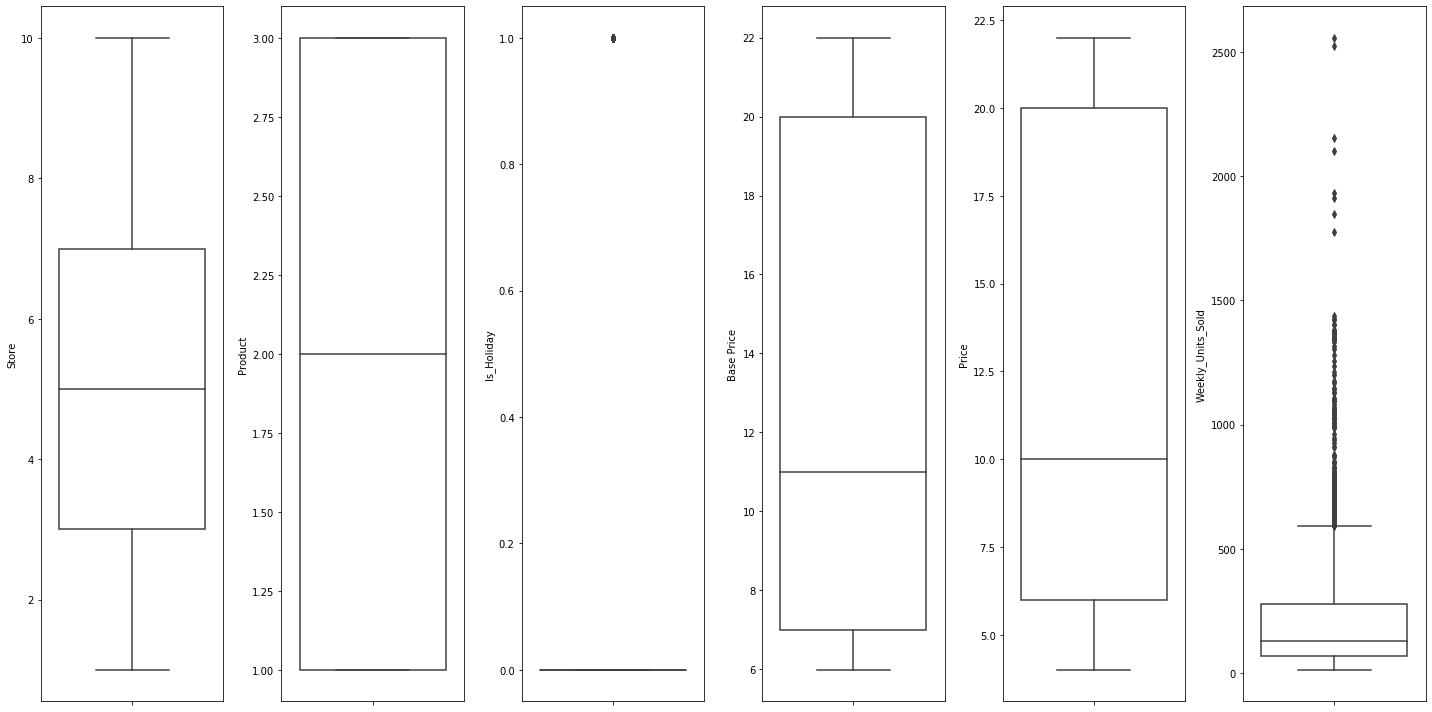


To check pairwise joint distribution of numeric data


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


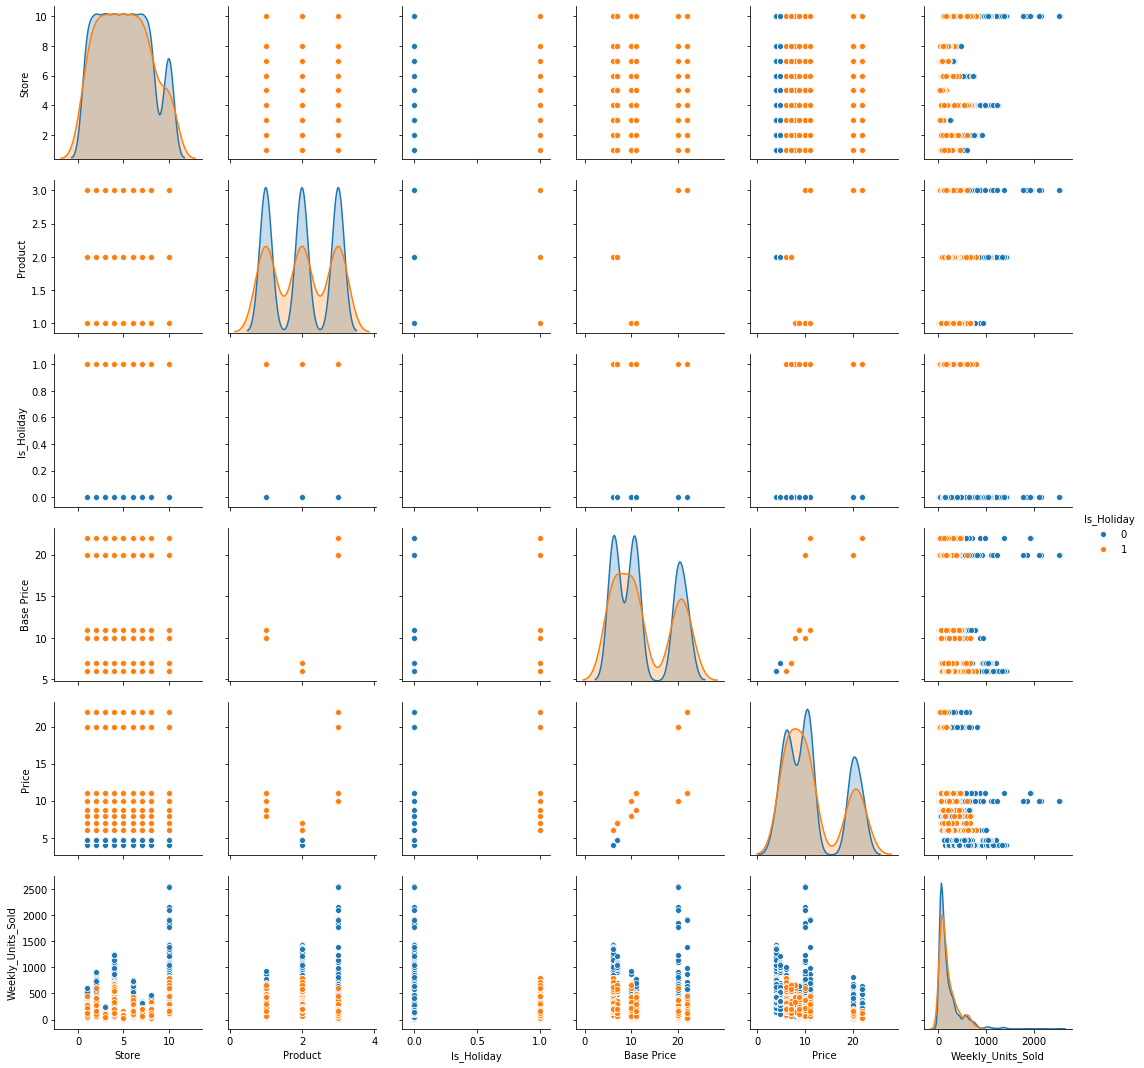

In [31]:
ana.numeric_eda(sp, hue="Is_Holiday")

It could be noticed that the units sold during holiday are relatively more constant than the days are not. 

### 1.5 Time Series Analysis

In [32]:
price = pd.DataFrame(sp.Price)
price.index = sp.Date

sale = pd.DataFrame(sp.Weekly_Units_Sold)
sale.index = sp.Date

price.head(), sale.head()

(            Price
 Date             
 2010-02-05   7.99
 2010-02-12   7.99
 2010-02-19   7.99
 2010-02-26   7.99
 2010-03-05   9.99,             Weekly_Units_Sold
 Date                         
 2010-02-05                245
 2010-02-12                453
 2010-02-19                409
 2010-02-26                191
 2010-03-05                145)

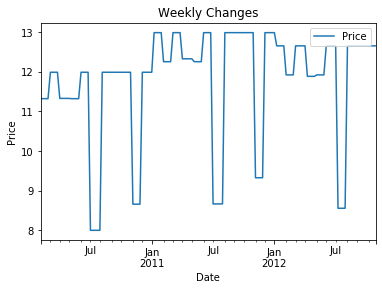

In [33]:
price.resample('W').mean().plot(title='Weekly Changes')
plt.ylabel('Price')
plt.show()

,Price
Date,
2010-12-31,"AxesSubplot(0.125,0.2;0.775x0.68)"
2011-12-31,"AxesSubplot(0.125,0.2;0.775x0.68)"
2012-12-31,"AxesSubplot(0.125,0.2;0.775x0.68)"


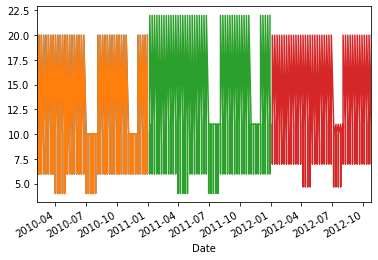

In [34]:
price.resample('Y').plot()

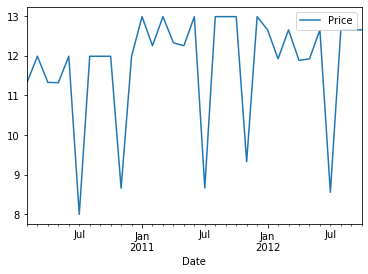

In [35]:
price.resample('M').mean().plot()

Based on the our time series analysis, the price shows an obvious trends on different months. So month and week are added to the dataframe for predicting the real price.

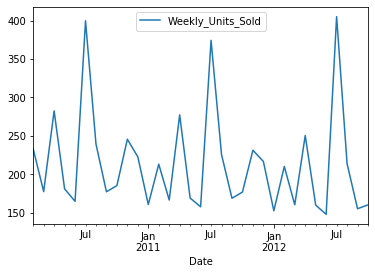

In [36]:
sale.resample('M').mean().plot()

Text(0, 0.5, 'The Amount of Sales')

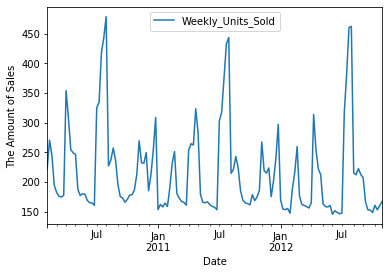

In [37]:
sale.resample('W').mean().plot()
plt.ylabel('The Amount of Sales')

Sold units also has a high relatinship with Date, and it shows opposite trends as the distribution of price. Besides, we could notice that each year shares the same trend. So price and weekly units sold are two interacted time series variables, and also the there exist seasonality of changes in price and sales, which indicates SARIMAX would be ideal model chosen to fit the data. LSTM also has the ability to predict long term dependency variables.

In [38]:
# sp['Month'] = sp.Date.dt.month
# sp['Week'] = sp.Date..week
# sp.drop(columns=['Date'], inplace=True)
# sp.head()

## 2 Model Selection & Metrics Check

In [39]:
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from math import log, exp
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.utils import check_array
def mean_absolute_percentage_error(y_true, y_pred): 
#     y_true, y_pred = check_array(y_true, y_pred)
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [40]:
#Test and Train split
split_train = int(sp.shape[0] * 0.8)

sp.sort_values(by=['Date'], inplace=True)
train_sp = sp[:split_train]
test_sp = sp[split_train:]

In [41]:
#ALL Valide History Data
price1_total = sp[sp.Product==1].drop(columns=['Product'])
price2_total = sp[sp.Product==2].drop(columns=['Product'])
price3_total = sp[sp.Product==3].drop(columns=['Product'])

for i in (price1_total, price2_total, price3_total):
    i.Date.sort_values()
    i.drop_duplicates(subset=['Date'], keep='first', inplace=True)
    i.index = i.Date
    i.drop(columns=['Date'], axis=1, inplace=True)

In [42]:
#Sperate the data based on Product types
sp1 = train_sp[train_sp.Product==1].drop(columns=['Product'])
sp2 = train_sp[train_sp.Product==2].drop(columns=['Product'])
sp3 = train_sp[train_sp.Product==3].drop(columns=['Product'])

sp1_test = test_sp[test_sp.Product==1].drop(columns=['Product'])
sp2_test = test_sp[test_sp.Product==2].drop(columns=['Product'])
sp3_test = test_sp[test_sp.Product==3].drop(columns=['Product'])

### 2.1 SARIMA

In [43]:
price1 = pd.DataFrame(sp1[['Price', 'Date']])
price2 = pd.DataFrame(sp2[['Price', 'Date']])
price3 = pd.DataFrame(sp3[['Price', 'Date']])

price1_test = pd.DataFrame(sp1_test[['Price', 'Date']])
price2_test = pd.DataFrame(sp2_test[['Price', 'Date']])
price3_test = pd.DataFrame(sp3_test[['Price', 'Date']])

In [44]:
sale1 = pd.DataFrame(sp1[['Weekly_Units_Sold', 'Date']])
sale2 = pd.DataFrame(sp2[['Weekly_Units_Sold', 'Date']])
sale3 = pd.DataFrame(sp3[['Weekly_Units_Sold', 'Date']])

In [45]:
for i in (price1, price2, price3, price1_test, price2_test, price3_test):
    i.drop_duplicates(subset=['Date'], keep='first', inplace=True)

In [46]:
for i in (price1, price2, price3):
    detect.dupli_detect(i)

No duplicated entries found
No duplicated entries found
No duplicated entries found


In [47]:
for i in (price1, price2, price3, price1_test, price2_test, price3_test):
    i.index = i.Date
    i.drop(columns=['Date'], inplace=True)

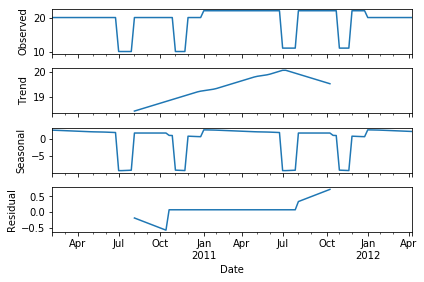

In [48]:
decomp = seasonal_decompose(price3, freq=52)
deplot = decomp.plot()
deplot.savefig('Product 3')

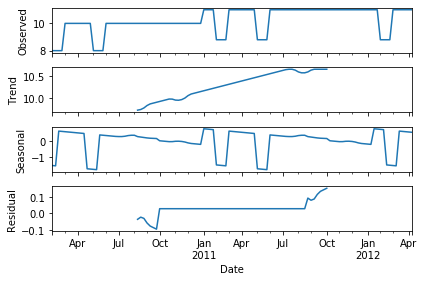

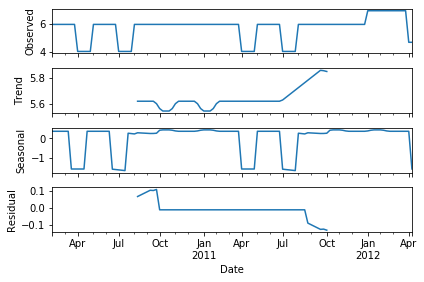

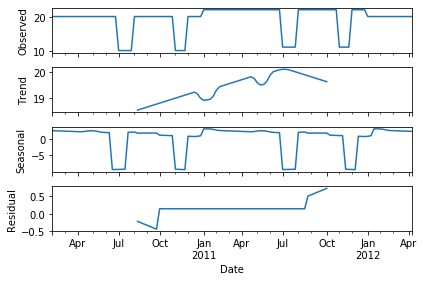

In [49]:
for i in (price1, price2, price3):
    decomp = seasonal_decompose(i, freq=54)
    deplot = decomp.plot()

In [50]:
print("Product 1 p-value:", adfuller(price1.Price)[1])
print("Product 2 p-value:", adfuller(price2.Price)[1])
print("Product 3 p-value:", adfuller(price3.Price)[1])

Product 1 p-value: 0.30105096049850116
Product 2 p-value: 0.4115182777335464
Product 3 p-value: 5.686766686017144e-06


In [51]:
class SModel(object):
    
    def selection(self, df):
        p = d = q = range(0, 2) # the number of observations don't support higher number {d + D*s + max(3*q + 1, 3*Q*s + 1, p, P*s) + 1 observations}
        pdq = list(itertools.product(p, d, q))
        seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]
        
        aic = {} # Taking as AIC indicator for selecting params

        for param in pdq:
            for param_seasonal in seasonal_pdq:
                try:
                    model = SARIMAX(df.Price,
                                    order=param,
                                    seasonal_order=param_seasonal,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

                    results = model.fit()
                    aic[(param, param_seasonal)] = results.aic
                except: 
                    continue
        re_df = pd.DataFrame.from_dict(aic, orient='index')
        self.params = re_df[0].idxmin()
        return self.params
    
    def modelfit(self, df, exog=None):
        
        model1 = SARIMAX(df.Price,
                         exog=exog, 
                         order=self.params[0],
                         seasonal_order=self.params[1], 
                         enforce_invertibility=False, 
                         enforce_stationarity=False)
        self.results = model1.fit()
        
        return self.results

    def trainperformance(self, df):
        y_train_pred = self.results.predict(start=53, end=df.shape[0]-1, dynamic=False)
        y_train = df.Price[53:]
        
        MAPE = mean_absolute_error(y_train, y_train_pred)
        R2 = r2_score(y_train, y_train_pred)
        
        print('MAPE train:', mean_absolute_percentage_error(y_train, y_train_pred))
        print('R2 train:', r2_score(y_train, y_train_pred))
        
        return MAPE, R2
    
    def visualization(self, df):
        ax = df.Price.plot(label = "observed")
        self.pred.predicted_mean.plot(label = 'predict', alpha=0.5, ax=ax)
        ax.fill_between(self.pred_ci.index,
                        self.pred_ci.iloc[:, 0],
                        self.pred_ci.iloc[:, 1], color='k', alpha=.2)
        ax.set_xlabel('Date', fontsize=15)
        ax.set_ylabel('Price', fontsize=15)
        plt.legend()
        plt.show()
        
    def performance(self, af):
        y_pred = self.results.forecast(steps=af.shape[0])
        y_true = af.Price
        
        MAPE = mean_absolute_error(y_true, y_pred)
        R2 = r2_score(y_true, y_pred)
        
        print('MAPE test:', mean_absolute_percentage_error(y_true, y_pred))
        print('R2 test:', r2_score(y_true, y_pred))
        
        return MAPE, R2

In [52]:
model = SModel()

In [53]:
model.selection(price2)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarn

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarn

((0, 1, 1), (1, 1, 0, 52))

In [54]:
model.modelfit(price2)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


In [55]:
y_train_pred = model.trainperformance(price2) # using price1, price2, price3 respectively

MAPE train: 2.29859054378026
R2 train: 0.8416741509525578


In [56]:
y_test_pred = model.performance(price2_test)

MAPE test: 8.257813825744389
R2 test: 0.29315636952851387


In [57]:
results = model.modelfit(price2_total) # using price1_total, price2_total and price3_total respectively
# ax = ap['1'].plot(label = "observed")


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


In [58]:
y_fore = results.forecast(steps=len(ap['2']))
mean_absolute_percentage_error(ap['2'], y_fore)


18.81169984941715

In [59]:
"""
Finding the best combination for SARIMA
"""
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [60]:
# Using AIC as indicator to evaluate the combinations
aic = {}

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(
                            order=param,
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            
            results = model.fit(price3.Price)
            aic[(param, param_seasonal)] = results.aic
#             print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue
            


In [ ]:
param

In [ ]:
model1 = SARIMAX(price3_total.Price, order=(1,0,0), 
                seasonal_order=(0, 0, 0, 52), 
                enforce_invertibility=False, 
                enforce_stationarity=False)
results = model1.fit()

In [ ]:
y_fore = results.forecast(steps=ap['3'].shape[0])
ax = ap['3'].plot(label = "observed")
y_fore.plot(label='forecast', c='r', alpha=0.5, ax=ax)
plt.legend()
plt.show()

In [ ]:
ypred = results.predict(start = 53, end = price3.shape[0]-1, dynamic=False)
print(mean_absolute_error(price3.Price[53:], ypred))
print('test r2', r2_score(price3.Price[53:], ypred))
y_forecast = results.forecast(steps=price3_test.shape[0])
print('test',mean_absolute_error(price3_test.Price, y_forecast))
print('test r2', r2_score(price3_test.Price, y_forecast))
ax = price3.Price.plot(label = "observed")
ypred.plot(label = 'predict', alpha=0.5, ax=ax)
y_forecast.plot(label = 'forecast', alpha=0.5, c='r', ax=ax)
price3_test.Price.plot(label='True Future',c='k', alpha=0.5, ax=ax)
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.show()

In [ ]:
#Find the right AR order, p, with PACF
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(311)
fig = plot_pacf(price1, lags=53, ax=ax1,
               title="Partial Autocorrelation on Product 1") # lag = 1, 5
ax2 = fig.add_subplot(312)
fig = plot_pacf(price2, lags=25, ax=ax2, 
               title="Partial Autocorrelation on Product 2") # lag = 1
ax3 = fig.add_subplot(313)
fig = plot_pacf(price3, lags=25, ax=ax3, 
               title="Partial Autocorrelation on Product 3") # lag = 1

In [ ]:
#Using AutoCorrelation Function to find the order of MA terms, q
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(311)
fig = plot_acf(price1, lags=25, ax=ax1,
               title="Autocorrelation on Product 1")
ax2 = fig.add_subplot(312)
fig = plot_acf(price2, lags=25, ax=ax2, 
               title="Autocorrelation on Product 2")
ax3 = fig.add_subplot(313)
fig = plot_acf(price3, lags=25, ax=ax3, 
               title="Autocorrelation on Product 3")

In [ ]:
price1.index.sort_values()

In [ ]:
y1_train = price1.Price[54:]
y1_pred = pred.predicted_mean

print(mean_absolute_error(y1_train, y1_pred))

In [ ]:
pred_uc = results.get_forecast(steps=12)
y_pred = pred_uc.predicted_mean
y_true = ap['1']
pred_ci = pred_uc.conf_int()

print(mean_absolute_error(y_true, y_pred))
# ax = ap['1'].plot(label='observed', figsize=(14, 4))
# pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
# ax.set_xlabel('Date')
# ax.set_ylabel('Price')
# plt.legend()
# plt.show()

## Summary and Insights

[matrix for evaluation]
The model I used to predict the future price is SARIMA and SARIMAX, it achieved the prediction MSE of xxx and the model explianed xxx% (R2) of the variance in the data. The results show that the prediction on price for the next 12 weeks is acceptable, which has around $1 difference between the real price and the predicted price.
To achieve a better prediction on price, if I have more time, another ML algorithm should be used, like LSTM, which has a great ability to predict long term dependencies. With the right choose of the filters, **dropback** ratio, it will give us a better prediction on price, since we could include more features into the model, like stores. Besides the algorithm, there are many key features which will highly influence the price, like the location, competitive products or substitute products and so on. What's more, if I was the owner, I will focus more on weekly units sales, which would provide more meaningful results to help the grow of stores. Based on the analysis, sales vary much in different stores, but the price don't, which means if we could successfully predict the number of sales for each store, we will have the chance to prepare enough products for the particular store to elevate the profit.
So if I could have the oppotunity to spend more time on this, a better prediction model would be 